In [17]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, MobileNet
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical, Sequence
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import resample

In [2]:
# Data augmentation and preprocessing
def preprocess_and_augment(data_paths, img_size):
    images = []
    labels = []

    for path in data_paths:
        for file_name in os.listdir(path):
            if file_name.endswith('.jpg') or file_name.endswith('.png'):
                try:
                    parts = file_name.split('_')
                    if len(parts) < 2:
                        continue
                    age = int(parts[0])  # Age
                    gender = int(parts[1])  # Gender
                    img_path = os.path.join(path, file_name)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (img_size, img_size))
                    img = img / 255.0  # Normalize
                    images.append(img)
                    labels.append([age, gender])
                except (ValueError, IndexError) as e:
                    print(f"Skipping file {file_name}: {e}")
                    continue

    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)

    return images, labels


In [3]:
data_paths = [
    'D:\\My_Projects\\Assigment\\c2c\\part1\\',
    'D:\\My_Projects\\Assigment\\c2c\\part2\\part2\\',
    'D:\\My_Projects\\Assigment\\c2c\\part3\\part3\\'
]
img_size = 128
batch_size = 32

images, labels = preprocess_and_augment(data_paths, img_size)

Skipping file 53__0_20170116184028385.jpg: invalid literal for int() with base 10: ''


In [6]:


gender_filtered_images = []
gender_filtered_labels = []

for img, lbl in zip(images, labels):
    if gender != 3:
        gender_filtered_images.append(img)
        gender_filtered_labels.append(lbl)

gender_filtered_images = np.array(gender_filtered_images)
gender_filtered_labels = np.array(gender_filtered_labels)

age_labels = gender_filtered_labels[:, 0]  
gender_labels = gender_filtered_labels[:, 1]  


In [7]:


male_images = []
male_labels = []
female_images = []
female_labels = []

for img, lbl in zip(gender_filtered_images, gender_filtered_labels):
    if lbl[1] == 0:  
        male_images.append(img)
        male_labels.append(lbl)
    elif lbl[1] == 1:  
        female_images.append(img)
        female_labels.append(lbl)

male_images = np.array(male_images)
male_labels = np.array(male_labels)
female_images = np.array(female_images)
female_labels = np.array(female_labels)

if len(male_images) > len(female_images):
    male_images, male_labels = resample(
        male_images,
        male_labels,
        replace=False,  
        n_samples=len(female_images),
        random_state=42
    )
elif len(female_images) > len(male_images):
    female_images, female_labels = resample(
        female_images,
        female_labels,
        replace=True,  
        n_samples=len(male_images),
        random_state=42
    )

balanced_images = np.concatenate((male_images, female_images), axis=0)
balanced_labels = np.concatenate((male_labels, female_labels), axis=0)

shuffled_indices = np.random.permutation(len(balanced_images))
balanced_images = balanced_images[shuffled_indices]
balanced_labels = balanced_labels[shuffled_indices]

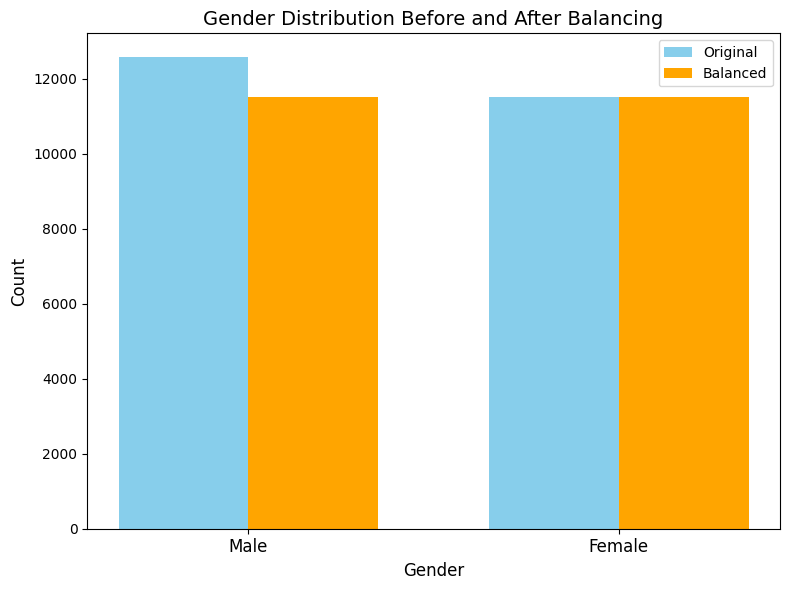

In [18]:
original_gender_counts = np.bincount(gender_filtered_labels[:, 1].astype(int))

# Count the number of samples for each gender after balancing
balanced_gender_counts = np.bincount(balanced_labels[:, 1].astype(int))

# Labels for the genders
gender_labels = ['Male', 'Female']

# Plotting the gender distribution
x = np.arange(len(gender_labels))  # Label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(8, 6))

# Bars for original data
ax.bar(x - width / 2, original_gender_counts, width, label='Original', color='skyblue')

# Bars for balanced data
ax.bar(x + width / 2, balanced_gender_counts, width, label='Balanced', color='orange')

# Adding labels, title, and legend
ax.set_xlabel('Gender', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Gender Distribution Before and After Balancing', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(gender_labels, fontsize=12)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

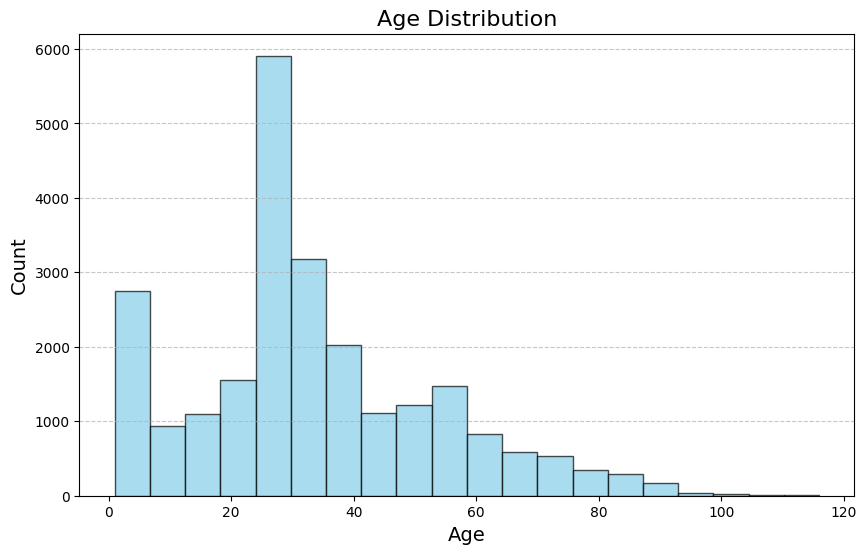

In [20]:

# Extract age labels
age_labels = gender_filtered_labels[:, 0]  # Assuming age is the first column

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(age_labels, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Age Distribution', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Freezed Model 

In [73]:


# Assuming images and labels are already loaded as numpy arrays
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Separate the labels into age and gender
train_ages = train_labels[:, 0]
train_genders = train_labels[:, 1]

val_ages = val_labels[:, 0]
val_genders = val_labels[:, 1]

# ImageDataGenerator for augmentation
data_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator for both age and gender labels
def train_gen():
    while True:
        # Generate augmented images and labels
        for batch_images in data_gen.flow(train_images, batch_size=32):
            batch_ages = train_ages[:len(batch_images)]
            batch_genders = train_genders[:len(batch_images)]
            
            yield batch_images, {'age_output': batch_ages, 'gender_output': batch_genders}

def val_gen():
    while True:
        # Generate augmented images and labels
        for batch_images in data_gen.flow(val_images, batch_size=32):
            batch_ages = val_ages[:len(batch_images)]
            batch_genders = val_genders[:len(batch_images)]
            
            yield batch_images, {'age_output': batch_ages, 'gender_output': batch_genders}


In [117]:


# Build the model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model layers

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

# Output for age prediction (regression)
age_output = layers.Dense(1, activation='linear', name='age_output')(x)

# Output for gender prediction (classification)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=[age_output, gender_output])

# Compile the model
model.compile(
    optimizer='adam',
    loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'},
    metrics={'age_output': 'mae', 'gender_output': 'accuracy'}
)

model.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)   │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 64, 64, 32)        │             864 │ input_layer_14[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 64, 64, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 64, 64, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 64, 64, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 64, 64, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 64, 64, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 64, 64, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 64, 64, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 64, 64, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 64, 64, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 64, 64, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 65, 65, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 32, 32, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [108]:

# Split the dataset into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(gender_filtered_images, gender_filtered_labels, test_size=0.2, random_state=42)

print(f"Train images shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Validation images shape: {X_val.shape}, Validation labels shape: {y_val.shape}")


Train images shape: (19283, 128, 128, 3), Train labels shape: (19283, 2)
Validation images shape: (4821, 128, 128, 3), Validation labels shape: (4821, 2)


In [109]:


class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size, dim, n_channels, n_classes, shuffle=True):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.images))  # All indexes of the dataset

    def __len__(self):
        # Returns the number of batches per epoch
        return int(np.floor(len(self.images) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            # Shuffle indexes after every epoch to ensure randomness
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        # Generate one batch of data
        batch_indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        batch_images = self.images[batch_indexes]
        batch_labels = self.labels[batch_indexes]

        # Here, we are assuming that labels contain both age and gender.
        # The labels are a dictionary like {'age_output': age_values, 'gender_output': gender_values}
        age_labels = batch_labels[:, 0]  # Age is the first label (assuming shape (n, 2) for age and gender)
        gender_labels = batch_labels[:, 1]  # Gender is the second label

        return batch_images, {'age_output': age_labels, 'gender_output': gender_labels}

# Create the data generators
train_gen = CustomDataGenerator(
    images=train_images, 
    labels=train_labels, 
    batch_size=32, 
    dim=(128, 128),  # Resize images to (128, 128)
    n_channels=3, 
    n_classes=2, 
    shuffle=True
)

val_gen = CustomDataGenerator(
    images=val_images, 
    labels=val_labels, 
    batch_size=32, 
    dim=(128, 128),  # Resize images to (128, 128)
    n_channels=3, 
    n_classes=2, 
    shuffle=False
)

# Calculate steps per epoch and validation steps
steps_per_epoch = len(train_images) // 32  # len(train_images) divided by batch size
validation_steps = len(val_images) // 32

# Train the model with the custom data generators
history = model.fit(
    train_gen,
    epochs=30,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)


Epoch 1/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 245s 387ms/step - age_output_loss: 469.2925 - age_output_mae: 16.7697 - gender_output_accuracy: 0.5150 - gender_output_loss: 1.8695 - loss: 471.1621 - val_age_output_loss: 337.5446 - val_age_output_mae: 14.3311 - val_gender_output_accuracy: 0.5492 - val_gender_output_loss: 0.7086 - val_loss: 338.2531
Epoch 2/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 223s 370ms/step - age_output_loss: 360.3070 - age_output_mae: 14.6476 - gender_output_accuracy: 0.5439 - gender_output_loss: 0.7108 - loss: 361.0178 - val_age_output_loss: 326.3844 - val_age_output_mae: 13.5523 - val_gender_output_accuracy: 0.5469 - val_gender_output_loss: 0.6860 - val_loss: 327.0704
Epoch 3/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 216s 359ms/step - age_output_loss: 340.0373 - age_output_mae: 14.1248 - gender_output_accuracy: 0.5614 - gender_output_loss: 0.6848 - loss: 340.7221 - val_age_output_loss: 316.8966 - val_age_output_mae: 13.6890 - val_gender_output_accuracy: 0.5523 - val_gender_output_loss: 0.

In [110]:
model.save("model/freeze_model.h5")

Model saved successfully.


# unfreeze model

In [14]:


# Assuming balanced_images and balanced_labels are already defined and concatenated

# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    balanced_images,
    balanced_labels,
    test_size=0.2,  # 20% for validation
    random_state=42,
    stratify=balanced_labels[:, 1]  # Stratify by gender labels to maintain balance
)

# Normalize the images
train_images = train_images / 255.0
val_images = val_images / 255.0

# Extract labels for age and gender
train_age_labels = train_labels[:, 0]  # Age
train_gender_labels = train_labels[:, 1]  # Gender (binary: 0 or 1)

val_age_labels = val_labels[:, 0]
val_gender_labels = val_labels[:, 1]

# Define a custom generator
def data_generator(images, age_labels, gender_labels, batch_size):
    while True:
        indices = np.random.permutation(len(images))
        for i in range(0, len(images), batch_size):
            batch_indices = indices[i:i + batch_size]
            yield images[batch_indices], {
                'age_output': age_labels[batch_indices],
                'gender_output': gender_labels[batch_indices]
            }

batch_size = 32
train_gen = data_generator(train_images, train_age_labels, train_gender_labels, batch_size)
val_gen = data_generator(val_images, val_age_labels, val_gender_labels, batch_size)

# Base Model: MobileNetV2
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Unfreeze the base model layers

# Add global pooling and dropout
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# Age output (Regression)
age_output = layers.Dense(1, activation='linear', name='age_output')(x)

# Gender output (Binary Classification)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=[age_output, gender_output])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        'age_output': 'mse',
        'gender_output': 'binary_crossentropy'
    },
    loss_weights={
        'age_output': 1.0,
        'gender_output': 0.5
    },
    metrics={
        'age_output': 'mae',
        'gender_output': 'accuracy'
    }
)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Training the model
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_images) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_images) // batch_size,
    epochs=30,
    callbacks=[reduce_lr, early_stopping]
)



Epoch 1/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 1560s 3s/step - age_output_loss: 1291.4703 - age_output_mae: 32.2786 - gender_output_accuracy: 0.5748 - gender_output_loss: 0.8926 - loss: 1291.9172 - val_age_output_loss: 1365.1791 - val_age_output_mae: 31.1812 - val_gender_output_accuracy: 0.5002 - val_gender_output_loss: 0.7313 - val_loss: 1365.5444 - learning_rate: 1.0000e-04
Epoch 2/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 1102s 2s/step - age_output_loss: 958.5080 - age_output_mae: 28.6684 - gender_output_accuracy: 0.6846 - gender_output_loss: 0.6759 - loss: 945.0353 - val_age_output_loss: 1377.3795 - val_age_output_mae: 31.3352 - val_gender_output_accuracy: 0.4993 - val_gender_output_loss: 1.0278 - val_loss: 1377.8934 - learning_rate: 1.0000e-04
Epoch 3/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 1114s 2s/step - age_output_loss: 540.5204 - age_output_mae: 21.0031 - gender_output_accuracy: 0.7010 - gender_output_loss: 0.6228 - loss: 541.0854 - val_age_output_loss: 814.2611 - val_age_output_mae: 22.8790 - val_gen

576/576 ━━━━━━━━━━━━━━━━━━━━ 1171s 2s/step - age_output_loss: 41.7876 - age_output_mae: 5.0376 - gender_output_accuracy: 0.7887 - gender_output_loss: 0.4361 - loss: 41.7409 - val_age_output_loss: 117.8918 - val_age_output_mae: 7.8297 - val_gender_output_accuracy: 0.7999 - val_gender_output_loss: 0.4299 - val_loss: 118.7926 - learning_rate: 1.0000e-04
Epoch 22/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 1209s 2s/step - age_output_loss: 38.9288 - age_output_mae: 4.8631 - gender_output_accuracy: 0.7978 - gender_output_loss: 0.4252 - loss: 38.8451 - val_age_output_loss: 123.9381 - val_age_output_mae: 8.0847 - val_gender_output_accuracy: 0.7886 - val_gender_output_loss: 0.4476 - val_loss: 121.1779 - learning_rate: 1.0000e-04
Epoch 23/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - age_output_loss: 39.8278 - age_output_mae: 4.8883 - gender_output_accuracy: 0.7843 - gender_output_loss: 0.4388 - loss: 39.1491
Epoch 23: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
576/576 ━━━━━━━━━━━━━━━

In [21]:
model.save("model/unfreeze_model.h5")